In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from zipfile import ZipFile as s

In [4]:

file_name = '/content/gdrive/MyDrive/icml_face_data.csv.zip'

with s(file_name, 'r') as zi:
  zi.extractall()
  print('Done')

Done


In [417]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical

In [6]:
data = pd.read_csv('/content/icml_face_data.csv')

In [7]:
data.head()


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [269]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [9]:
data[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

In [10]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [11]:

train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [12]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

In [13]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

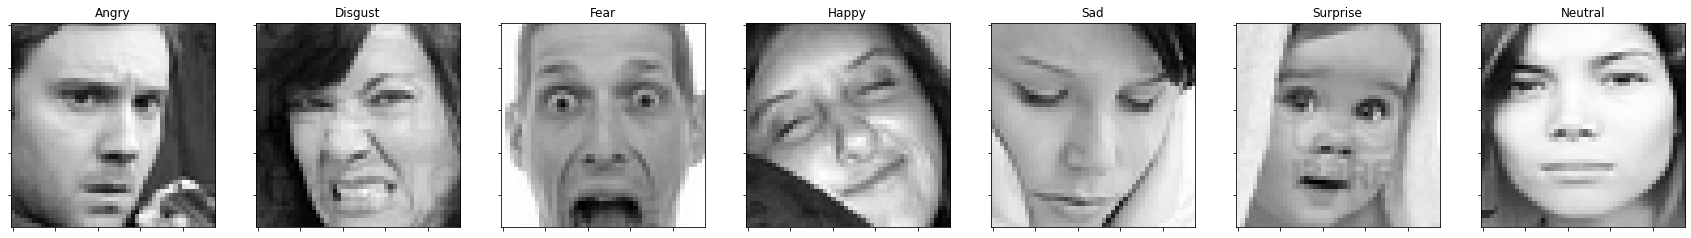

In [ ]:
plot_all_emotions()

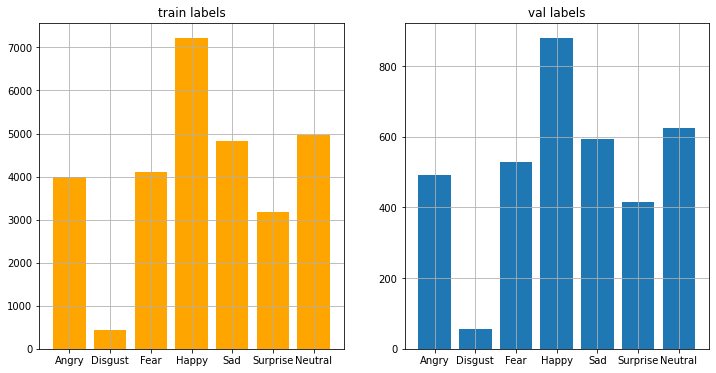

In [ ]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

In [14]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

In [15]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

In [500]:
import pandas as pd
from matplotlib import pyplot
from math import sqrt 
import numpy as np 
import scipy.misc 
from IPython.display import display 
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
#%matplotlib inline
#data= pd.read_csv('../input/fer2013.csv')
#data.head()

In [501]:
def FER_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)

    #the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)

    #the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)

    #the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)

    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)

    #Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)

    # create model 
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())
    
    return model

In [534]:
model = FER_Model()
opt = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) 

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_17 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_18 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0   

In [535]:
from keras.callbacks import ModelCheckpoint
filepath="/content/weights_min_loss.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [539]:
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    callbacks=callbacks_list,
                    epochs=10,
                    batch_size=64)

Epoch 1/10
449/449 [==============================] - ETA: 0s - loss: 0.1716 - accuracy: 0.5738
Epoch 1: val_loss improved from 1.22668 to 1.15898, saving model to /content/weights_min_loss.hdf5
449/449 [==============================] - 32s 70ms/step - loss: 0.1716 - accuracy: 0.5738 - val_loss: 1.1590 - val_accuracy: 0.5734
Epoch 2/10
448/449 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.5874
Epoch 2: val_loss did not improve from 1.15898
449/449 [==============================] - 32s 71ms/step - loss: 0.1657 - accuracy: 0.5872 - val_loss: 1.1969 - val_accuracy: 0.5639
Epoch 3/10
448/449 [============================>.] - ETA: 0s - loss: 0.1592 - accuracy: 0.6014
Epoch 3: val_loss improved from 1.15898 to 1.13970, saving model to /content/weights_min_loss.hdf5
449/449 [==============================] - 32s 71ms/step - loss: 0.1592 - accuracy: 0.6014 - val_loss: 1.1397 - val_accuracy: 0.5829
Epoch 4/10
449/449 [==============================] - ETA: 0s - loss

In [537]:
#

In [412]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [448]:
from keras import backend as K
#K.set_image_dim_ordering('th')

In [447]:
def swish_activation(x):
    return (K.sigmoid(x) * x)

In [470]:
model = models.Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(48,48,1)))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation=swish_activation))
model.add(Dropout(0.4))
model.add(Dense(7 , activation='softmax'))

In [471]:
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])


In [505]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0     

In [486]:
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=10,
                    batch_size=64)

Epoch 1/10
449/449 [==============================] - 7s 16ms/step - loss: 0.0924 - accuracy: 0.7679 - val_loss: 1.4909 - val_accuracy: 0.5631
Epoch 2/10
449/449 [==============================] - 7s 16ms/step - loss: 0.0809 - accuracy: 0.7952 - val_loss: 1.5762 - val_accuracy: 0.5614
Epoch 3/10
449/449 [==============================] - 7s 16ms/step - loss: 0.0703 - accuracy: 0.8226 - val_loss: 1.5714 - val_accuracy: 0.5734
Epoch 4/10
449/449 [==============================] - 7s 16ms/step - loss: 0.0593 - accuracy: 0.8480 - val_loss: 1.8413 - val_accuracy: 0.5651
Epoch 5/10
449/449 [==============================] - 7s 16ms/step - loss: 0.0516 - accuracy: 0.8659 - val_loss: 1.9452 - val_accuracy: 0.5623
Epoch 6/10
449/449 [==============================] - 7s 16ms/step - loss: 0.0451 - accuracy: 0.8843 - val_loss: 2.0660 - val_accuracy: 0.5531
Epoch 7/10
449/449 [==============================] - 7s 17ms/step - loss: 0.0394 - accuracy: 0.8970 - val_loss: 2.2087 - val_accuracy: 0.5648

In [540]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test accuracy:', test_acc)

113/113 [==============================] - 2s 14ms/step - loss: 1.1883 - accuracy: 0.6230
test accuracy: 0.6230147480964661


In [473]:
pred_test_labels = model.predict(test_images)

113/113 [==============================] - 1s 4ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(test_labels, axis = 1 ),pred_test_labels,digits=3))

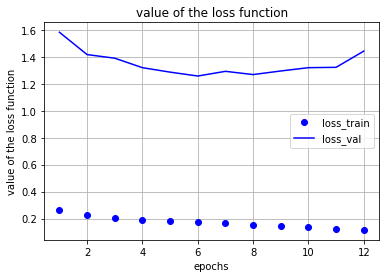

In [22]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

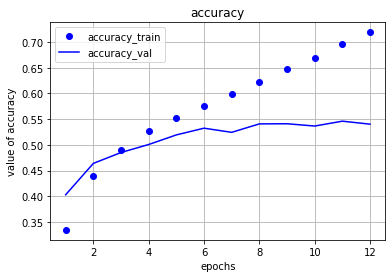

In [23]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

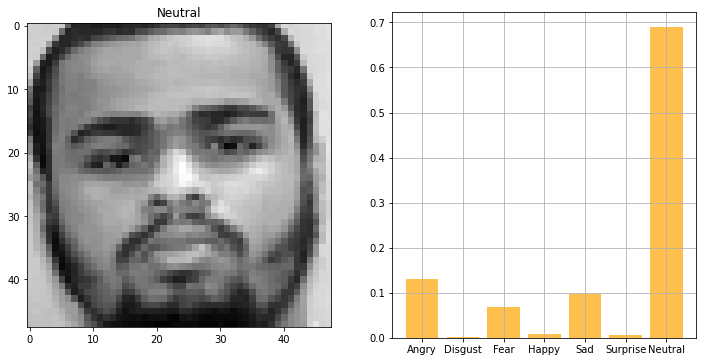

In [24]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 106)

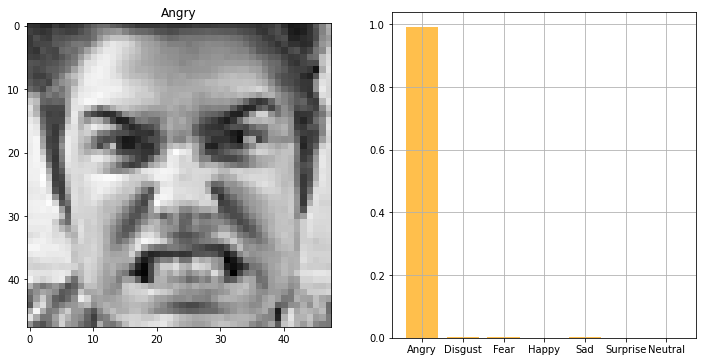

In [25]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 40)

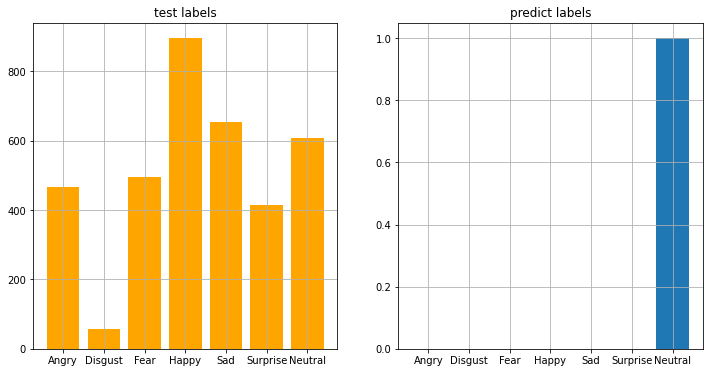

In [533]:
plot_compare_distributions(test_labels, pred_test_labels, title1='test labels', title2='predict labels')

In [ ]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

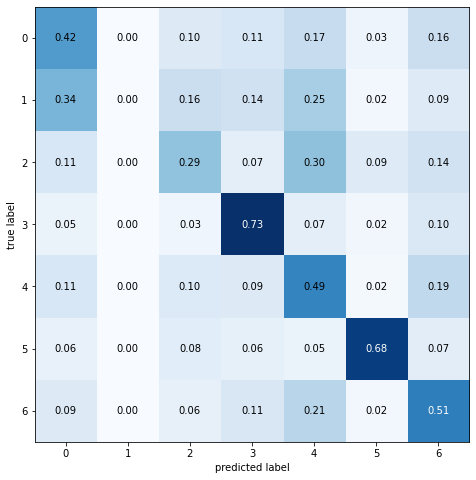

In [ ]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                
                                figsize=(8, 8))
fig.show()

In [ ]:
class_names=emotions.values(),